In [1]:
import os
import cv2
import tqdm
import torch
import pathlib

import numpy as np
import albumentations as A

from PIL import Image
from pathlib import Path
from albumentations.pytorch import ToTensorV2
from transformers import SegformerForSemanticSegmentation


/media/matej/B4085A48085A09AE/Posao/Transformers-Playground/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
id2label = { 0: 'background', 1: 'fire' }
label2id = { 'background': 0, 'fire': 1 }

model_checkpoint = "nvidia/mit-b3"

models_data = [
    {
        'model_name': 'SegFormer 256x256',
        'model_path': r'/media/matej/B4085A48085A09AE/Posao/Transformers-Playground/checkpoints/segformer/scarlet-totem-58',
        'patch_size': 256,
    },
]

model_idx = 0

val_transforms = A.Compose(
    [
        ToTensorV2(),
    ],
)

In [3]:
def _resize_and_pad(image: np.array, 
                    new_shape,
                    padding_color = (0, 0, 0)
                ) -> np.array:
        """
        Maintains aspect ratio and resizes with padding.
        Params:
            image: Image to be resized.
            new_shape: Expected (width, height) of new image.
            padding_color: Tuple in BGR of padding color
        Returns:
            image: Resized image with padding
        """
        original_shape = (image.shape[1], image.shape[0])
        ratio = float(max(new_shape)) / max(original_shape)
        new_size = tuple([int(x*ratio) for x in original_shape])
        image = cv2.resize(image, new_size)
 
        delta_w = new_shape[0] - new_size[0]
        delta_h = new_shape[1] - new_size[1]
        top, bottom = delta_h//2, delta_h-(delta_h//2)
        left, right = delta_w//2, delta_w-(delta_w//2)
 
        image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=padding_color)
        return image

def preload_image_data(data_dir, img_dir, is_mask: bool = False, patch_size: int = 256, dataset_list = 'test_dataset.txt'):
    """
        Loads all images from data_dir.
    """
    dataset_files = []
    dataset_file_names = []
    with open(pathlib.Path('/media/matej/B4085A48085A09AE/Posao/Transformers-Playground', data_dir, dataset_list), mode='r', encoding='utf-8') as file:
        for i, line in enumerate(file):
            path = pathlib.Path('/media/matej/B4085A48085A09AE/Posao/Transformers-Playground', data_dir, img_dir, line.strip(), f'Image/{line.strip()}.png' if is_mask == False else f'Mask/0.png')
            img = None

            # Load image
            if is_mask:
                img = np.array(Image.open(str(path)).convert("L")) #cv2.imread(str(Path(info.mask, '0.png')), cv2.IMREAD_GRAYSCALE)
                img = _resize_and_pad(img, (patch_size, patch_size), (0, 0, 0)).astype(np.float32)
            else:
                img = np.array(Image.open(str(path)).convert("RGB"))  #cv2.imread(str(Path(info.image, os.listdir(info.image)[0])))
                img = _resize_and_pad(img, (patch_size, patch_size), (0, 0, 0)).astype(np.float32)

            dataset_files.append(img)
            dataset_file_names.append(line.strip())

    return dataset_files, dataset_file_names

def load_checkpoint(path: Path):
    if not path.is_file():
        best_path = Path(path, 'best-checkpoint.pth.tar')
        if best_path.is_file():
            path = best_path
        else:
            path = Path(path, 'checkpoint.pth.tar')

    if not path.is_file():
        return
    
    model = SegformerForSemanticSegmentation.from_pretrained(
        model_checkpoint,
        num_labels=2,
        id2label=id2label, 
        label2id=label2id,
        reshape_last_stage=True,
        ignore_mismatched_sizes=True,
    )

    state_dict = torch.load(path)    
    model.load_state_dict(state_dict['model_state'])

    return model

In [4]:
imgs, _ = preload_image_data(r'dataset', r'imgs', False, models_data[model_idx]['patch_size'], f'test_dataset.txt')
masks, _ = preload_image_data(r'dataset', r'imgs', True, models_data[model_idx]['patch_size'], f'test_dataset.txt')

In [23]:
model = load_checkpoint(Path(models_data[model_idx]['model_path'])).cuda()
model.eval()
torch.compile(model)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b3 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


OptimizedModule(
  (_orig_mod): SegformerForSemanticSegmentation(
    (segformer): SegformerModel(
      (encoder): SegformerEncoder(
        (patch_embeddings): ModuleList(
          (0): SegformerOverlapPatchEmbeddings(
            (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
            (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          )
          (1): SegformerOverlapPatchEmbeddings(
            (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          )
          (2): SegformerOverlapPatchEmbeddings(
            (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
          )
          (3): SegformerOverlapPatchEmbeddings(
            (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
           

In [33]:
img_idx = 69

data = val_transforms(image=imgs[img_idx])
data['image'] = data['image'].unsqueeze(0).cuda()

In [35]:
with torch.no_grad():
    outputs = model(data['image'])
    logits = outputs.logits
    masks_pred = torch.nn.functional.interpolate(logits, size=data['image'].shape[-2:], mode="bilinear", align_corners=False)
    masks_pred = masks_pred.argmax(dim=1)

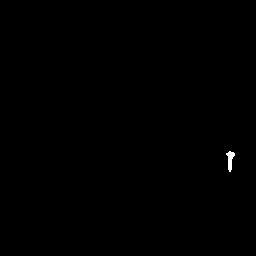

In [36]:
masks_pred = masks_pred.cpu().numpy()
Image.fromarray(masks_pred[0].astype(np.uint8) * 255)